In [1]:
# Author: Dr. Christian Kehl
%pylab inline
import matplotlib
import numpy as np
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from datetime import timedelta as delta

import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
import cartopy.feature as cfeature

from IPython.display import Image, HTML, display
from CloudFileHelper import *
from argparse import ArgumentParser
import xarray as xr
import math
import os

Populating the interactive namespace from numpy and matplotlib


In [2]:
%load_ext autoreload
%autoreload 2
%load_ext version_information
%version_information numpy, matplotlib, xarray, cartopy


filedir = os.path.abspath(".")
headdir = os.path.abspath(os.path.join(filedir, ".."))
vdir = os.path.join(headdir, "images")
ifile_random = "southern_currents_CMEMS_rin_random_resize.png"
ifile_random_path = os.path.join(vdir, ifile_random)
ifile_random_large_path = os.path.join(vdir, "southern_currents_CMEMS_rin_random_resize.bak.png")
ifile_sequential = "southern_currents_CMEMS_rin_sequential_resize.png"
ifile_sequential_path = os.path.join(vdir, ifile_sequential)
ifile_sequential_large_path = os.path.join(vdir, "southern_currents_CMEMS_rin_sequential_resize.bak.png")
ifile_ordered = "southern_currents_CMEMS_rin_ordered_resize.png"
ifile_ordered_path = os.path.join(vdir, ifile_ordered)
ifile_ordered_large_path = os.path.join(vdir, "southern_currents_CMEMS_rin_ordered_resize.bak.png")

This notebook shows how to plot transparent particles in an order-independent way to avoid the following confuser:

File: /git/parcels_gallery/images/southern_currents_CMEMS_rin_random_resize.bak.png


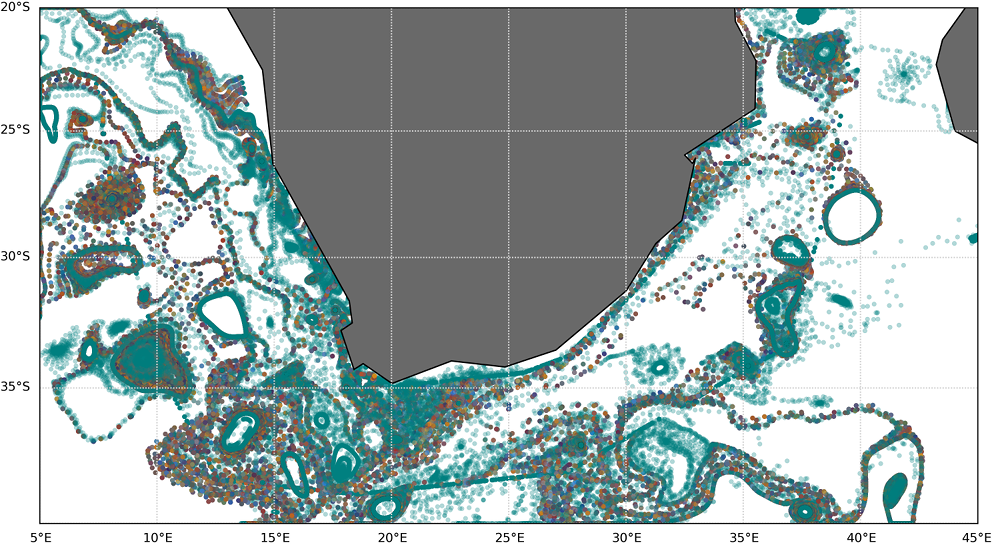

Particles with starting-season attribute; random order.


In [3]:
if os.path.exists(ifile_random_large_path):
    print("File: {}".format(ifile_random_large_path))
    display(Image(filename=ifile_random_large_path, embed=True))
    print("Particles with starting-season attribute; random order.")

File: /git/parcels_gallery/images/southern_currents_CMEMS_rin_sequential_resize.bak.png


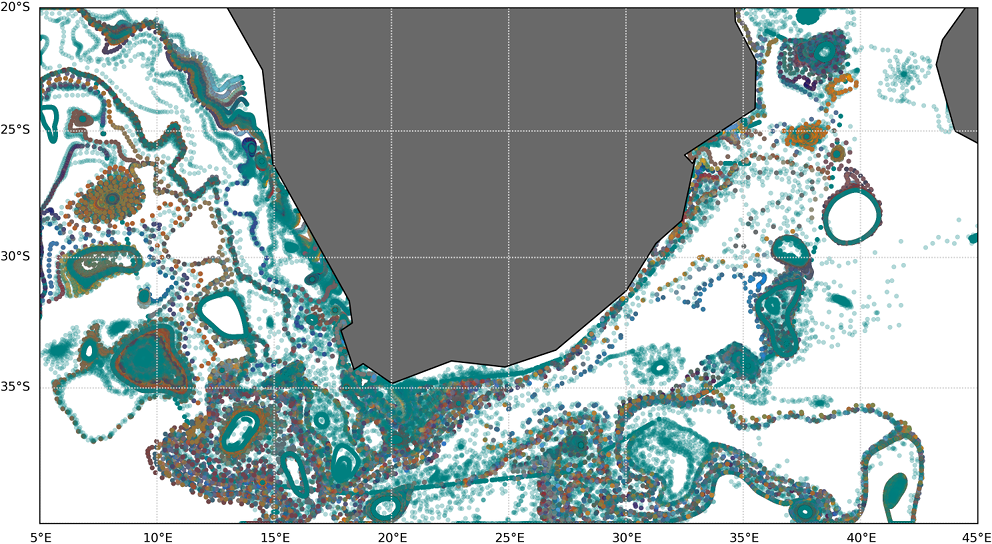

Particles with starting-season attribute; sequential order.


In [4]:
if os.path.exists(ifile_sequential_large_path):
    print("File: {}".format(ifile_sequential_large_path))
    display(Image(filename=ifile_sequential_large_path, embed=True))
    print("Particles with starting-season attribute; sequential order.")

File: /git/parcels_gallery/images/southern_currents_CMEMS_rin_ordered_resize.bak.png


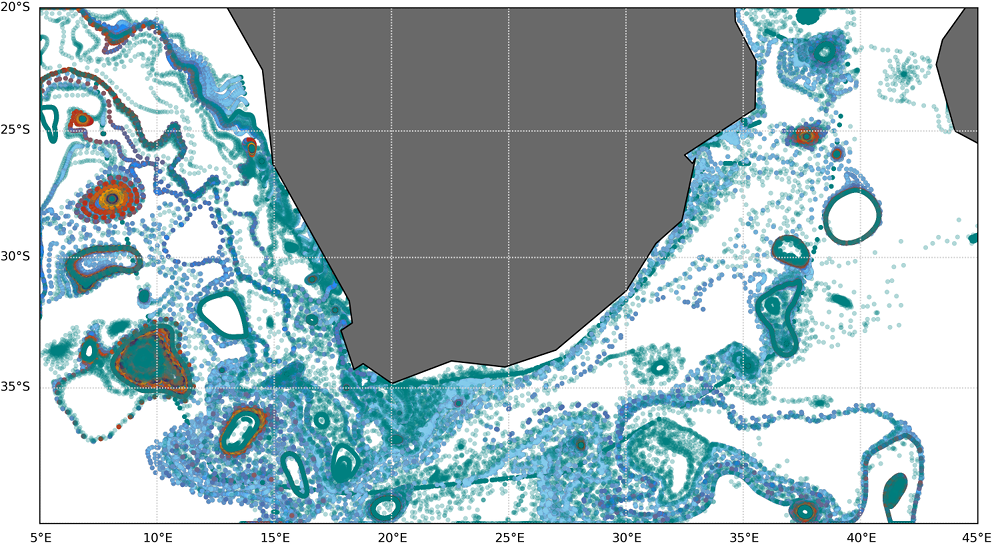

Particles with starting-season attribute; ascending order to head attribute.


In [5]:
if os.path.exists(ifile_ordered_large_path):
    print("File: {}".format(ifile_ordered_large_path))
    display(Image(filename=ifile_ordered_large_path, embed=True))
    print("Particles with starting-season attribute; ascending order to head attribute.")

In these images, we plot one and the same data, which are continuously-released particles in the southern ocean. 
The particles are rendered as semi-transparent circles, where the colour depicts the season in which each particle was 
released. In such a setup, especially when using transparency as a visual information channel, a pre-ordering of the data,
in our case the _season_ attribute, is important for a consistent plot that always depicts the same figure irrespective of
how the data are ordered-in and read-from files.

In our example, particles with later seasons need to be plotted over earlier particles, as they are otherwise hidden. 
The first image shows a plot from a random particle order, while the second figure plots the particels sequentially in 
the ordered the are written in the file. In both cases, the later particles are covered by earlier particles. Correctly-done,
as in the third figure, the particles are pre-ordered (ascendingly) according to the _season_ value, so that the last 
plotted particles are also the ones with the latest season.

This notebook explains how to arrive at those plots. 

First of all, we create 2 support fuctions: 1 that sets up the geographic plot with a basemap, including the contour 
and filler of the continental mass. The second function actually adds a layer to the existing plot with the given _lat_, 
_lon_ and _label_ values (where the latter is our _season_ attribute). This latter function has two important switches for 
our case study: the switch _'random_shuffle'_ controls doing a sequential (= False) or a randomized (= True) order; the 
switch _'labelsort'_ controls ascending ordering of particles (i.e. _lat_, _lon_ and _label_) being done (= True) or not 
(= False). 

In [6]:
def setup_scatterplot(lonlat_minmax, solid_coastline=True, land=True):
    """
    Sets up the basemap projection for the 2D scatterplot. Basemap from 'cartopy' and the 'mpl_toolkits.basemap'.
    :param lonlat_minmax:
    :param solid_coastline:
    :param land:
    :return:
    """
    fig = plt.figure(figsize=(12, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())

    ax.set_xlim([5, 45])
    ax.set_ylim([-40.0, -20.0])
    
    resol = '10m' if solid_coastline else None  # use data at this scale
    if land:
        land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale=resol, edgecolor='k', facecolor=cfeature.COLORS['land'])
        ax.add_feature(land, facecolor='dimgray') #beige
    ocean = cartopy.feature.NaturalEarthFeature('physical', 'ocean', scale=resol, edgecolor='none', facecolor=cfeature.COLORS['water'])
    ax.add_feature(ocean, facecolor='white', linewidth=0.2)
    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.8, color='gray', alpha=0.75, linestyle='-', zorder=1000)
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlines = True
    gl.ylines = True
    gl.xlocator = mticker.FixedLocator([5, 10, 15, 20, 25, 30, 35, 40, 45])
    gl.ylocator = mticker.FixedLocator([-40, -35, -30, -25, -20]) #np.arange(30., 42, 3)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.ylabel_style = {'size': 9}
    gl.xlabel_style = {'size': 9}
    return fig, ax

def populated_scatterplot(ax, bmap, lons, lats, labels, size=4, cmap=None, norm=None,
                          cbar=True, random_shuffle=True, labelsort=False, t=0, alpha=0.6, zorder=1):
    """
    For earth surface: Scatter positions at certain time t with color map given by labels
    - ax: pyplot axis
    - bmap: previously-created basemap
    - labels: colors
    - size: markersize in plot
    - cmap: colormap
    - norm: norm for colorbar
    - cbar: Plots cbar for True
    - random_shuffle: if True, randomly shuffle particles and labels such that
    not one color completely covers the other
    - t: particle time for plotting
    - alpha: transparency of scatter points
    """
    plt.sca(ax)
    lon_plot = lons
    lat_plot = lats
    N_local = lons.shape[0]

    if random_shuffle:
        indices = np.arange(0, N_local, dtype=int)
        np.random.shuffle(indices)
        lon_plot = lon_plot[indices]
        lat_plot = lat_plot[indices]
        labels = labels[indices]
    elif labelsort:
        indices = np.argsort(labels)
        lon_plot = lon_plot[indices]
        lat_plot = lat_plot[indices]
        labels = labels[indices]
    else:
        pass

    ls = size / 50.0
    if cmap == None:
        p = ax.scatter(lon_plot, lat_plot, s=size, linewidths=ls, c=labels, alpha=alpha, zorder=zorder)
    else:
        p = ax.scatter(lon_plot, lat_plot, s=size, linewidths=ls, c=labels, cmap=cmap, norm=norm, alpha=alpha, zorder=zorder)

    return ax, p

Now, first of all (if plotting needs to be done anew), we download- and load-in the particle data. 


In [7]:
# ==== Setup- and general settings ==== #
np.set_printoptions(linewidth=160)
filedir = os.path.abspath(".")
pfile_name = "southern_currents_OFAM_noMPI_p_fwd_age_static.nc"
pfile_path = os.path.join(filedir, pfile_name)
# ---- general simulation information ---- #
sec_per_day = 86400.0
ns_per_sec = np.timedelta64(1, 's')  # nanoseconds in an sec
time_in_days = 730
ot_hours = 24
t = delta(days=time_in_days).total_seconds()
dt = delta(hours=ot_hours).total_seconds()
tN_t = int(round(t/dt))+1
t_months = int(math.ceil(time_in_days/30.0))
tn_per_month = int(round((30.0*24.0) / ot_hours))
# ---- setting up general plot settings ---- #
plot_cbar = True
selective = True
store_shuffle = False
store_invert = False
random_shuffle = False
labelsort = True
sratio = 0.9
alpha = 0.3
colours = np.array(['teal', 
                    'dimgray', 
                    'sienna', 
                    'midnightblue', 
                    'orange', 
                    'firebrick', 
                    'aqua', 
                    'dodgerblue', 
                    'skyblue', 
                    'coral', 
                    'purple', 
                    'mediumaquamarine', 
                    'k'])

# ==== create post-read accessible variables ==== #
N = None
time_array = None
Pn = None
tN = None
sim_dt = None
pX, pY, pLabels = None, None, None
min_x, max_x = None, None
min_y, max_y = None, None
min_l, max_l = None, None
L = None

In [8]:
if not os.path.exists(ifile_random_path) or not os.path.exists(ifile_sequential_path) or not os.path.exists(ifile_ordered_path):
    if not os.path.exists(pfile_path):
        get_from_surfdrive("https://surfdrive.surf.nl/files/index.php/s/XTcOxJEBUU38PBq", pfile_path)
    
    data_xarray = xr.open_dataset(pfile_path)
    ctime_array = data_xarray['time'].data
    timebase = ctime_array[0]
    dtime_array = ctime_array-timebase
    time_array = dtime_array / ns_per_sec
    N = data_xarray['lon'].data.shape[0]
    Pn = int(N*sratio)
    tN = data_xarray['lon'].data.shape[1]
    assert tN_t == tN, "counted dt ({}) does not match tN ({})".format(tN_t, tN)
    print("N: {}, Pn: {}, t_N: {}".format(N, Pn, tN))
    
    if Pn == N:
        indices = np.arange(0, N, dtype=int)
    elif not selective:
        indices = np.random.randint(0, N-1, Pn, dtype=int)
    else:
        steps = int(1.0/sratio)
        indices = np.arange(start=0, stop=N, step=steps, dtype=int)
        if store_shuffle:
            np.random.shuffle(indices)
        if store_invert:
            indices = np.flip(indices)
    time_since_release = (time_array.transpose() - time_array[:, 0])
    sim_dt = time_since_release[1,0] - time_since_release[0,0]
    
    
    pX = data_xarray['lon'].data[indices, :]
    pY = data_xarray['lat'].data[indices, :]
    pLabels = data_xarray['label'].data[indices, :]
    min_x = np.nanmin(pX)
    min_x = np.floor(min_x/0.5)*0.5
    max_x = np.nanmax(pX)
    max_x = np.ceil(max_x/0.5)*0.5
    min_y = np.nanmin(pY)
    min_y = np.floor(min_y/0.5)*0.5
    max_y = np.nanmax(pY)
    max_y = np.ceil(max_y/0.5)*0.5
    min_l = np.nanmin(pLabels)
    max_l = np.nanmax(pLabels)
    L = int(max_l-min_l)
    print("L - min: {}, max: {}, range: {}".format(min_l, max_l, L))

N: 1198, Pn: 1078, t_N: 731
L - min: 0.0, max: 8.0, range: 8


Next, let's actualy plot the basic, sequential-order plot.

start: 0, end: 30, |lon|: (9584,), |lat|: (9584,), |lbl|: (9584,), max-L: 0.0
start: 30, end: 60, |lon|: (9584,), |lat|: (9584,), |lbl|: (9584,), max-L: 0.0
start: 60, end: 90, |lon|: (9584,), |lat|: (9584,), |lbl|: (9584,), max-L: 0.0
start: 90, end: 120, |lon|: (9584,), |lat|: (9584,), |lbl|: (9584,), max-L: 1.0
start: 120, end: 150, |lon|: (9584,), |lat|: (9584,), |lbl|: (9584,), max-L: 1.0
start: 150, end: 180, |lon|: (9584,), |lat|: (9584,), |lbl|: (9584,), max-L: 1.0
start: 180, end: 210, |lon|: (9584,), |lat|: (9584,), |lbl|: (9584,), max-L: 2.0
start: 210, end: 240, |lon|: (9584,), |lat|: (9584,), |lbl|: (9584,), max-L: 2.0
start: 240, end: 270, |lon|: (9584,), |lat|: (9584,), |lbl|: (9584,), max-L: 2.0
start: 270, end: 300, |lon|: (9584,), |lat|: (9584,), |lbl|: (9584,), max-L: 3.0
start: 300, end: 330, |lon|: (9584,), |lat|: (9584,), |lbl|: (9584,), max-L: 3.0
start: 330, end: 360, |lon|: (9584,), |lat|: (9584,), |lbl|: (9584,), max-L: 3.0
start: 360, end: 390, |lon|: (9584,)

/var/scratch/bin-x86_64/anaconda/envs/OpenParcels_MPI/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/var/scratch/bin-x86_64/anaconda/envs/OpenParcels_MPI/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


start: 420, end: 450, |lon|: (9584,), |lat|: (9584,), |lbl|: (9584,), max-L: 4.0
start: 450, end: 480, |lon|: (9584,), |lat|: (9584,), |lbl|: (9584,), max-L: 5.0
start: 480, end: 510, |lon|: (9584,), |lat|: (9584,), |lbl|: (9584,), max-L: 5.0
start: 510, end: 540, |lon|: (9584,), |lat|: (9584,), |lbl|: (9584,), max-L: 5.0
start: 540, end: 570, |lon|: (9584,), |lat|: (9584,), |lbl|: (9584,), max-L: 6.0
start: 570, end: 600, |lon|: (9584,), |lat|: (9584,), |lbl|: (9584,), max-L: 6.0
start: 600, end: 630, |lon|: (9584,), |lat|: (9584,), |lbl|: (9584,), max-L: 6.0
start: 630, end: 660, |lon|: (9584,), |lat|: (9584,), |lbl|: (9584,), max-L: 7.0
start: 660, end: 690, |lon|: (9584,), |lat|: (9584,), |lbl|: (9584,), max-L: 7.0
start: 690, end: 720, |lon|: (9584,), |lat|: (9584,), |lbl|: (9584,), max-L: 7.0
start: 720, end: 730, |lon|: (3594,), |lat|: (3594,), |lbl|: (3594,), max-L: 7.0


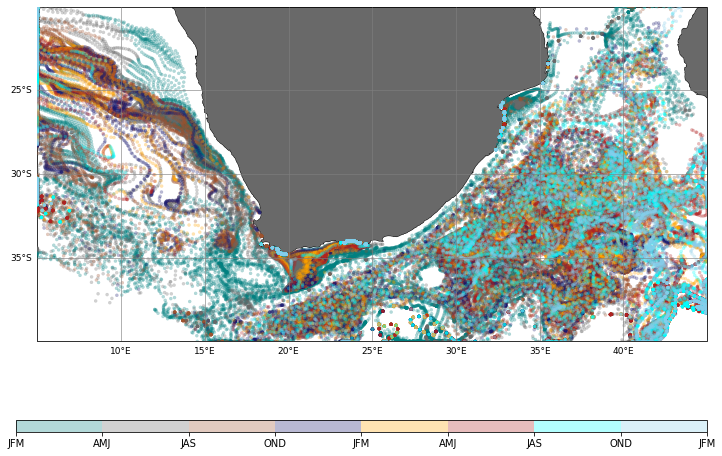

In [9]:
if N is not None and not os.path.exists(ifile_random_path):
    # ==== plot random image ==== #
    bounds = np.arange(min_l-0.5, max_l+0.5, 1.0, dtype=np.float32)
    norm = matplotlib.colors.BoundaryNorm(bounds, len(bounds))
    cmap = matplotlib.colors.ListedColormap(colours, colours.shape[0])
    bmap, ax = setup_scatterplot(lonlat_minmax=[min_x, min_y, max_x, max_y], solid_coastline=True, land=True)

    p = None
    months = np.arange(start=0, stop=t_months, dtype=np.int32)
    time_traversal = months.tolist()
    zorder = 10
    for i in time_traversal:
        start = int(i*tn_per_month)
        end = min(int((i+1)*tn_per_month), pX.shape[1]-1)
        p_lons = np.array(pX[:, start:end:4].flatten())
        p_lats = np.array(pY[:, start:end:4].flatten())
        p_labels = np.array(pLabels[:, start:end:4].flatten())
        print("start: {}, end: {}, |lon|: {}, |lat|: {}, |lbl|: {}, max-L: {}".format(start, end, p_lons.shape, p_lats.shape, p_labels.shape, np.nanmax(p_labels)))
        ax, p = populated_scatterplot(ax=ax, bmap=bmap, lons=p_lons, lats=p_lats, labels=p_labels, size=10, cmap=cmap, norm=norm, cbar=True, random_shuffle=False, labelsort=False, t=tN-1, alpha=alpha, zorder=zorder)
        zorder += 1
    
    if plot_cbar:
        ax_cbar_h5a_w = bmap.add_axes([0.1, 0.055, 0.8, 0.02])
        cbar = plt.colorbar(p, cax=ax_cbar_h5a_w, ticks=bounds, aspect=10, orientation='horizontal')
        tick_labels = ["JFM", "AMJ", "JAS", "OND",
                       "JFM", "AMJ", "JAS", "OND",
                       "JFM", "AMJ", "JAS", "OND",
                       "JFM", "AMJ", "JAS", "OND",
                       "JFM", "AMJ", "JAS", "OND",
                       "JFM", "AMJ", "JAS", "OND",
                       "JFM", "AMJ", "JAS", "OND",
                       "JFM", "AMJ", "JAS", "OND",
                       "JFM", "AMJ", "JAS", "OND",
                       "JFM", "AMJ", "JAS", "OND"]
        cbar.ax.set_xticklabels(tick_labels[0:L+1])
    plt.savefig(ifile_random_path, dpi=72)
    plt.show()
    plt.close()
else:
    display(Image(filename=ifile_random_path, embed=True))

Next, let's actualy plot the random-order figure.

start: 0, end: 30, |lon|: (9584,), |lat|: (9584,), |lbl|: (9584,), max-L: 0.0
start: 30, end: 60, |lon|: (9584,), |lat|: (9584,), |lbl|: (9584,), max-L: 0.0
start: 60, end: 90, |lon|: (9584,), |lat|: (9584,), |lbl|: (9584,), max-L: 0.0
start: 90, end: 120, |lon|: (9584,), |lat|: (9584,), |lbl|: (9584,), max-L: 1.0
start: 120, end: 150, |lon|: (9584,), |lat|: (9584,), |lbl|: (9584,), max-L: 1.0
start: 150, end: 180, |lon|: (9584,), |lat|: (9584,), |lbl|: (9584,), max-L: 1.0
start: 180, end: 210, |lon|: (9584,), |lat|: (9584,), |lbl|: (9584,), max-L: 2.0
start: 210, end: 240, |lon|: (9584,), |lat|: (9584,), |lbl|: (9584,), max-L: 2.0
start: 240, end: 270, |lon|: (9584,), |lat|: (9584,), |lbl|: (9584,), max-L: 2.0
start: 270, end: 300, |lon|: (9584,), |lat|: (9584,), |lbl|: (9584,), max-L: 3.0
start: 300, end: 330, |lon|: (9584,), |lat|: (9584,), |lbl|: (9584,), max-L: 3.0
start: 330, end: 360, |lon|: (9584,), |lat|: (9584,), |lbl|: (9584,), max-L: 3.0
start: 360, end: 390, |lon|: (9584,)

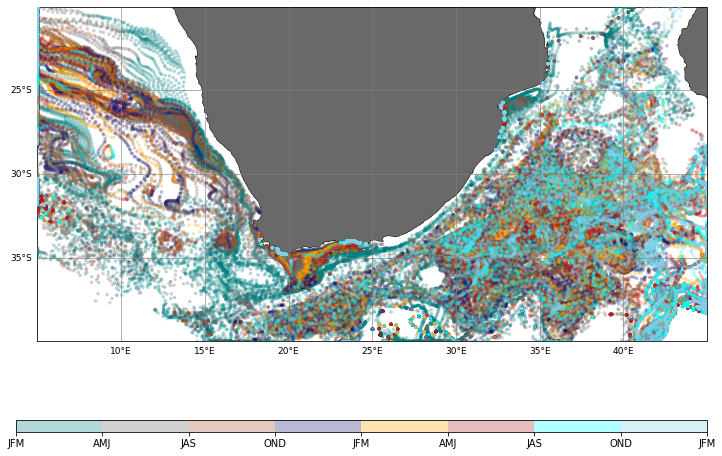

In [10]:
if N is not None and not os.path.exists(ifile_sequential_path):
    # ==== plot random image ==== #
    bounds = np.arange(min_l-0.5, max_l+0.5, 1.0, dtype=np.float32)
    norm = matplotlib.colors.BoundaryNorm(bounds, len(bounds))
    cmap = matplotlib.colors.ListedColormap(colours, colours.shape[0])
    bmap, ax = setup_scatterplot(lonlat_minmax=[min_x, min_y, max_x, max_y], solid_coastline=True, land=True)

    p = None
    months = np.arange(start=0, stop=t_months, dtype=np.int32)
    time_traversal = months.tolist()
    zorder = 10
    for i in time_traversal:
        start = int(i*tn_per_month)
        end = min(int((i+1)*tn_per_month), pX.shape[1]-1)
        p_lons = np.array(pX[:, start:end:4].flatten())
        p_lats = np.array(pY[:, start:end:4].flatten())
        p_labels = np.array(pLabels[:, start:end:4].flatten())
        print("start: {}, end: {}, |lon|: {}, |lat|: {}, |lbl|: {}, max-L: {}".format(start, end, p_lons.shape, p_lats.shape, p_labels.shape, np.nanmax(p_labels)))
        ax, p = populated_scatterplot(ax=ax, bmap=bmap, lons=p_lons, lats=p_lats, labels=p_labels, size=10, cmap=cmap, norm=norm, cbar=True, random_shuffle=True, labelsort=False, t=tN-1, alpha=alpha, zorder=zorder)
        zorder += 1
    
    if plot_cbar:
        ax_cbar_h5a_w = bmap.add_axes([0.1, 0.055, 0.8, 0.02])
        cbar = plt.colorbar(p, cax=ax_cbar_h5a_w, ticks=bounds, aspect=10, orientation='horizontal')
        tick_labels = ["JFM", "AMJ", "JAS", "OND",
                       "JFM", "AMJ", "JAS", "OND",
                       "JFM", "AMJ", "JAS", "OND",
                       "JFM", "AMJ", "JAS", "OND",
                       "JFM", "AMJ", "JAS", "OND",
                       "JFM", "AMJ", "JAS", "OND",
                       "JFM", "AMJ", "JAS", "OND",
                       "JFM", "AMJ", "JAS", "OND",
                       "JFM", "AMJ", "JAS", "OND",
                       "JFM", "AMJ", "JAS", "OND"]
        cbar.ax.set_xticklabels(tick_labels[0:L+1])
    plt.savefig(ifile_sequential_path, dpi=72)
    plt.show()
    plt.close()
else:
    display(Image(filename=ifile_sequential_path, embed=True))

Lastly we actualy plot the ascendingly-ordered particles according to the _season_ value.

start: 0, end: 30, |lon|: (9584,), |lat|: (9584,), |lbl|: (9584,), max-L: 0.0
start: 30, end: 60, |lon|: (9584,), |lat|: (9584,), |lbl|: (9584,), max-L: 0.0
start: 60, end: 90, |lon|: (9584,), |lat|: (9584,), |lbl|: (9584,), max-L: 0.0
start: 90, end: 120, |lon|: (9584,), |lat|: (9584,), |lbl|: (9584,), max-L: 1.0
start: 120, end: 150, |lon|: (9584,), |lat|: (9584,), |lbl|: (9584,), max-L: 1.0
start: 150, end: 180, |lon|: (9584,), |lat|: (9584,), |lbl|: (9584,), max-L: 1.0
start: 180, end: 210, |lon|: (9584,), |lat|: (9584,), |lbl|: (9584,), max-L: 2.0
start: 210, end: 240, |lon|: (9584,), |lat|: (9584,), |lbl|: (9584,), max-L: 2.0
start: 240, end: 270, |lon|: (9584,), |lat|: (9584,), |lbl|: (9584,), max-L: 2.0
start: 270, end: 300, |lon|: (9584,), |lat|: (9584,), |lbl|: (9584,), max-L: 3.0
start: 300, end: 330, |lon|: (9584,), |lat|: (9584,), |lbl|: (9584,), max-L: 3.0
start: 330, end: 360, |lon|: (9584,), |lat|: (9584,), |lbl|: (9584,), max-L: 3.0
start: 360, end: 390, |lon|: (9584,)

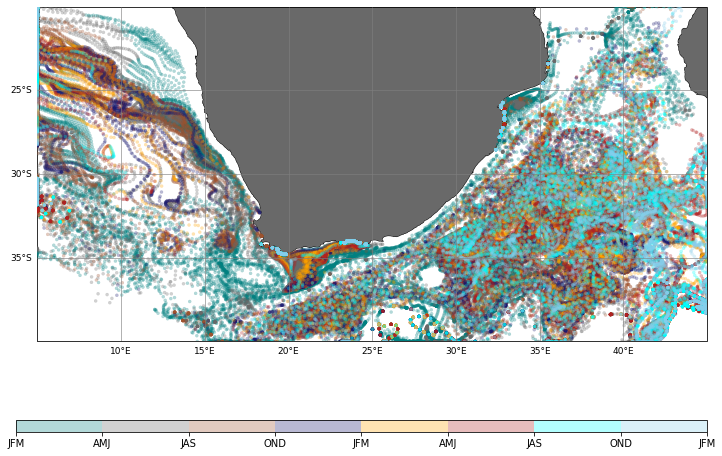

In [11]:
if N is not None and not os.path.exists(ifile_ordered_path):
    # ==== plot random image ==== #
    bounds = np.arange(min_l-0.5, max_l+0.5, 1.0, dtype=np.float32)
    norm = matplotlib.colors.BoundaryNorm(bounds, len(bounds))
    cmap = matplotlib.colors.ListedColormap(colours, colours.shape[0])
    bmap, ax = setup_scatterplot(lonlat_minmax=[min_x, min_y, max_x, max_y], solid_coastline=True, land=True)

    p = None
    months = np.arange(start=0, stop=t_months, dtype=np.int32)
    time_traversal = months.tolist()
    zorder = 10
    for i in time_traversal:
        start = int(i*tn_per_month)
        end = min(int((i+1)*tn_per_month), pX.shape[1]-1)
        p_lons = np.array(pX[:, start:end:4].flatten())
        p_lats = np.array(pY[:, start:end:4].flatten())
        p_labels = np.array(pLabels[:, start:end:4].flatten())
        print("start: {}, end: {}, |lon|: {}, |lat|: {}, |lbl|: {}, max-L: {}".format(start, end, p_lons.shape, p_lats.shape, p_labels.shape, np.nanmax(p_labels)))
        ax, p = populated_scatterplot(ax=ax, bmap=bmap, lons=p_lons, lats=p_lats, labels=p_labels, size=10, cmap=cmap, norm=norm, cbar=True, random_shuffle=False, labelsort=True, t=tN-1, alpha=alpha, zorder=zorder)
        zorder += 1
    
    if plot_cbar:
        ax_cbar_h5a_w = bmap.add_axes([0.1, 0.055, 0.8, 0.02])
        cbar = plt.colorbar(p, cax=ax_cbar_h5a_w, ticks=bounds, aspect=10, orientation='horizontal')
        tick_labels = ["JFM", "AMJ", "JAS", "OND",
                       "JFM", "AMJ", "JAS", "OND",
                       "JFM", "AMJ", "JAS", "OND",
                       "JFM", "AMJ", "JAS", "OND",
                       "JFM", "AMJ", "JAS", "OND",
                       "JFM", "AMJ", "JAS", "OND",
                       "JFM", "AMJ", "JAS", "OND",
                       "JFM", "AMJ", "JAS", "OND",
                       "JFM", "AMJ", "JAS", "OND",
                       "JFM", "AMJ", "JAS", "OND"]
        cbar.ax.set_xticklabels(tick_labels[0:L+1])
    plt.savefig(ifile_ordered_path, dpi=72)
    plt.show()
    plt.close()
else:
    display(Image(filename=ifile_ordered_path, embed=True))


In [12]:
if os.path.exists(os.path.join(filedir, pfile_name)):
    os.remove(os.path.join(filedir, pfile_name))